In [1]:
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet import autograd
import numpy as np
import pickle as p
import mxnet as mx
from time import time
import matplotlib.pyplot as plt
ctx = mx.gpu()

In [2]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

In [3]:
route = '/home/sinyer/Python/data'
train_num = 50000
test_num = 10000
batch_size = 256
def load_CIFAR_batch(filename):
    with open(filename, 'rb')as f:
        data_dict = p.load(f, encoding='latin1')
        X = data_dict['data']
        Y = data_dict['labels']
        X = X.reshape(10000, 3, 32,32).astype("float")
        Y = np.array(Y)
        return X, Y
def load_CIFAR_Labels(filename):
    with open(filename, 'rb') as f:
        label_names = p.load(f, encoding='latin1')
        names = label_names['label_names']
        return names
label_names = load_CIFAR_Labels(route + "/cifar-10-batches-py/batches.meta")
img_X1, img_Y1 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_1")
img_X2, img_Y2 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_2")
img_X3, img_Y3 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_3")
img_X4, img_Y4 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_4")
img_X5, img_Y5 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_5")
test_pic, test_label = load_CIFAR_batch(route + "/cifar-10-batches-py/test_batch")
train_pic = np.concatenate((img_X1, img_X2, img_X3, img_X4, img_X5))
train_label = np.concatenate((img_Y1, img_Y2, img_Y3, img_Y4, img_Y5))
X = train_pic[:train_num,:].astype('float32')/255
y = train_label[:train_num].astype('float32')
X_ = test_pic[:test_num,:].astype('float32')/255
y_ = test_label[:test_num].astype('float32')
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
for i in range(3):
    X[:,:,:,i] = (X[:,:,:,i] - mean[i]) / std[i]
    X_[:,:,:,i] = (X_[:,:,:,i] - mean[i]) / std[i]
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_, y_), batch_size, shuffle=False)

In [4]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128, activation="relu"),
        nn.Dense(10)
    )
net.initialize(ctx=ctx)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02, 'momentum': 0.9, 'wd': 5e-4})

Epoch 0, Loss: 2.005221, Train acc 0.264441, Test acc 0.407227, Time 1.913024
Epoch 10, Loss: 0.754186, Train acc 0.736842, Test acc 0.638770, Time 1.465410
Epoch 20, Loss: 0.327546, Train acc 0.884881, Test acc 0.662695, Time 1.489466
Epoch 30, Loss: 0.118390, Train acc 0.961735, Test acc 0.660352, Time 1.486733
Epoch 40, Loss: 0.012030, Train acc 0.999621, Test acc 0.680762, Time 1.464054
Epoch 50, Loss: 0.010898, Train acc 0.999960, Test acc 0.685742, Time 1.463517
Epoch 60, Loss: 0.009008, Train acc 1.000000, Test acc 0.686133, Time 1.463117
Epoch 70, Loss: 0.009438, Train acc 1.000000, Test acc 0.685352, Time 1.505319


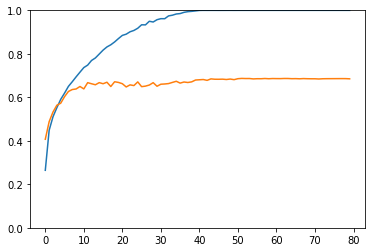

In [5]:
epochs = 80
lr_period = 50
lr_decay = 0.1

a = []
b = []
for epoch in range(epochs):
    if epoch > 0 and epoch % lr_period == 0:
        trainer.set_learning_rate(trainer.learning_rate * lr_decay)
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            L = loss(output, label)
        L.backward()
        trainer.step(data.shape[0])
        train_loss += nd.mean(L).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%10 == 0:
        print("Epoch %d, Loss: %f, Train acc %f, Test acc %f, Time %f" % (epoch, train_loss/batch, train_acc/batch, test_acc, time() - start))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0, 1)
plt.show()